Copyright © 2023 "Bronte" Sihan Li

## Implement the transfer learning tutorial
This is based on the tutorial on transfer learning [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning%20ant%20bees).

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'files/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

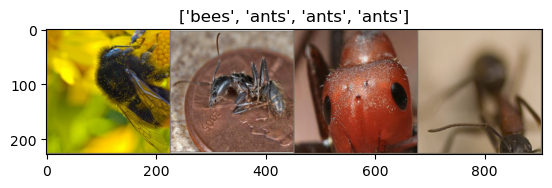

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/apple/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.5921 Acc: 0.6885


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.1767 Acc: 0.9412

Epoch 1/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.6798 Acc: 0.7459


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2259 Acc: 0.9150

Epoch 2/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.4184 Acc: 0.8361


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.3514 Acc: 0.8431

Epoch 3/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.5659 Acc: 0.7828


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2466 Acc: 0.9085

Epoch 4/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.5320 Acc: 0.8074


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.3157 Acc: 0.8758

Epoch 5/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.6823 Acc: 0.7787


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2476 Acc: 0.9085

Epoch 6/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.4789 Acc: 0.8156


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.3545 Acc: 0.8693

Epoch 7/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.3555 Acc: 0.8320


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.3162 Acc: 0.8824

Epoch 8/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.3862 Acc: 0.8402


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2801 Acc: 0.8824

Epoch 9/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.3105 Acc: 0.8607


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2672 Acc: 0.9085

Epoch 10/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.3127 Acc: 0.8648


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2754 Acc: 0.9150

Epoch 11/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.2878 Acc: 0.8934


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2646 Acc: 0.8954

Epoch 12/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.1947 Acc: 0.9180


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2979 Acc: 0.8889

Epoch 13/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.2774 Acc: 0.8689


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2490 Acc: 0.9020

Epoch 14/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.2627 Acc: 0.8975


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2782 Acc: 0.9020

Epoch 15/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.2545 Acc: 0.8811


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2788 Acc: 0.8889

Epoch 16/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.3262 Acc: 0.8648


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2866 Acc: 0.9020

Epoch 17/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.2377 Acc: 0.8975


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.3464 Acc: 0.8627

Epoch 18/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.3443 Acc: 0.8525


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2599 Acc: 0.9085

Epoch 19/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.2750 Acc: 0.8811


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2546 Acc: 0.9216

Epoch 20/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.3717 Acc: 0.8607


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2424 Acc: 0.9216

Epoch 21/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.2522 Acc: 0.8852


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2533 Acc: 0.9085

Epoch 22/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.2633 Acc: 0.8852


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2965 Acc: 0.8758

Epoch 23/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.2915 Acc: 0.8893


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2499 Acc: 0.9150

Epoch 24/24
----------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

train Loss: 0.2739 Acc: 0.8730


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

val Loss: 0.2515 Acc: 0.9150

Training complete in 28m 47s
Best val Acc: 0.941176


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
/opt

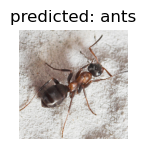

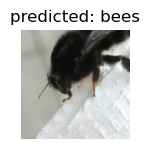

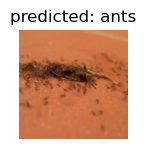

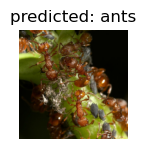

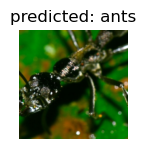

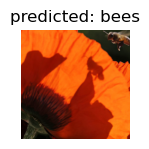

In [8]:
visualize_model(model_ft)

In [ ]:
torch.save(model_ft.state_dict(), 'files/model_ft.pth')